In [190]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams

In [191]:
%matplotlib inline

restaurant_orders = pd.read_csv('files/lesson_7/train.csv', sep =',')# parse_dates=['date_oper'], dayfirst=True
restaurant_orders['date'] = pd.to_datetime(restaurant_orders.date,format='%d.%m.%Y') 
restaurant_orders

,date_id,date,orders
0,1,2018-07-01,2285
1,2,2018-07-02,1670
2,3,2018-07-03,2341
3,4,2018-07-04,1781
4,5,2018-07-05,1737
5,6,2018-07-06,2210
6,7,2018-07-07,2824
7,8,2018-07-08,3141
8,9,2018-07-09,2089
9,10,2018-07-10,1989


In [239]:
restaurant_orders.index  = restaurant_orders.date
train = restaurant_orders.sort_values('date', ascending = True).iloc[40:]
test = restaurant_orders.sort_values('date', ascending = True).iloc[-18:]

/home/evgenii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/home/evgenii/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


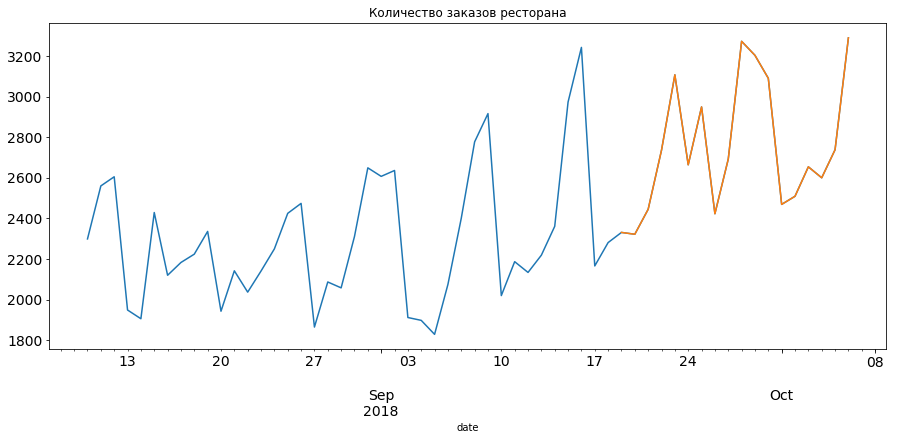

In [240]:
train.orders.plot( figsize=(15,6),title= 'Количество заказов ресторана', fontsize=14)
test.orders.plot( figsize=(15,6),title= 'Количество заказов ресторана', fontsize=14)
plt.show()

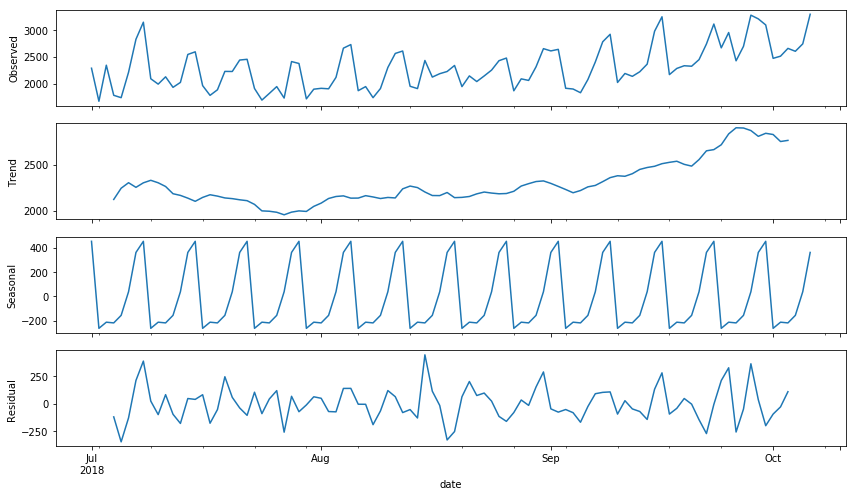

In [241]:
# STL-декомпозиция ряда
rcParams['figure.figsize'] = 12, 7
sm.tsa.seasonal_decompose(restaurant_orders.orders).plot()
plt.show()

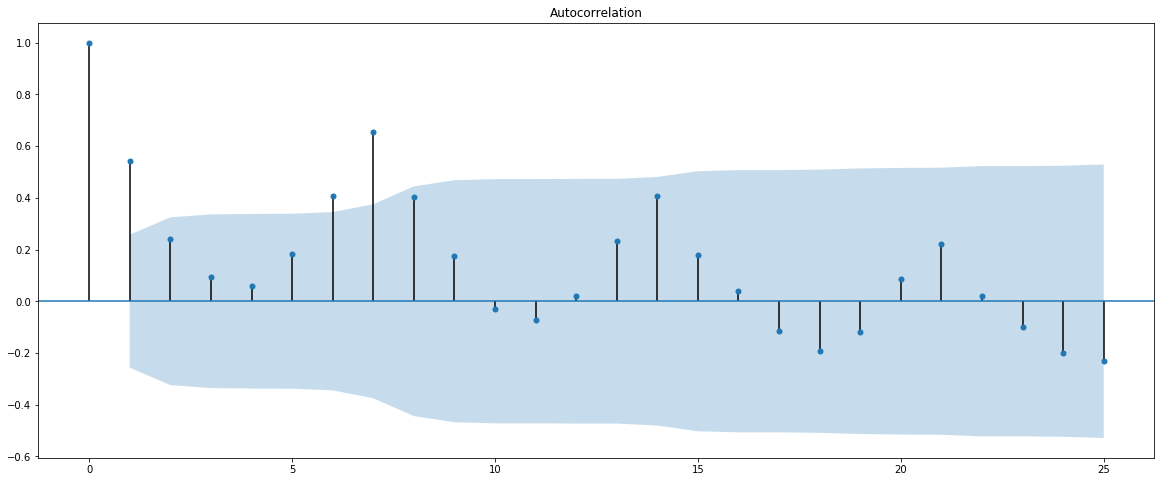

In [242]:
#Коррелограмма
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(train.orders.values, lags=25,ax = ax)
plt.show()

In [243]:
y_hat = test.copy()

In [244]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

### Метод линейного тренда Холта-Уинтерса

Подходит для работы с временными рядами, где есть устойчивый линейный тренд.

У нас есть следующие компоненты:

- линейное уравнение для построения прогноза    
${y}_{x+1} = \ell_x + b_x$    
- уравнение уровня    
$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$
- уравнение тренда    
${b_x} = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$


Итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [245]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result[-1]

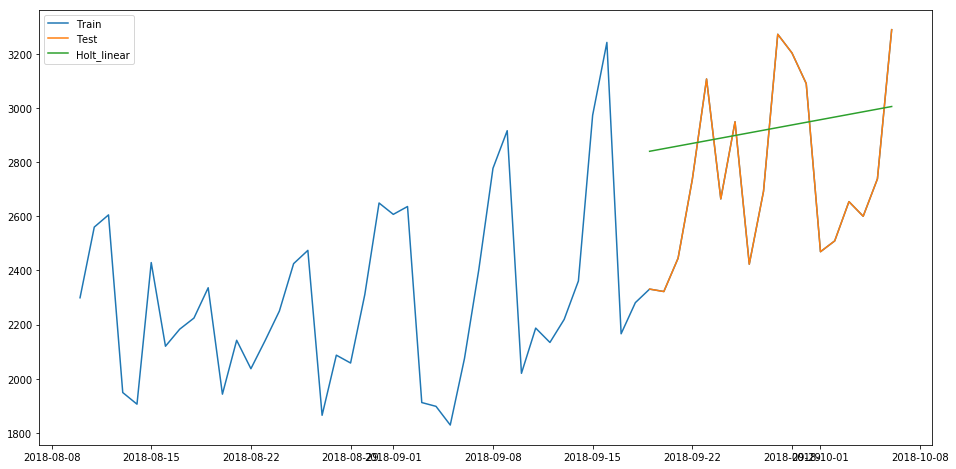

In [246]:
fit1 = Holt(np.asarray(train.orders)).fit(smoothing_level = 0.28,smoothing_slope = 0.27)
y_hat['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train.orders, label='Train')
plt.plot(test.orders, label='Test')
plt.plot(y_hat['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [247]:
rms = sqrt(mean_squared_error(test.orders, y_hat.Holt_linear))
print(rms)

347.5644206305956


### Метод Холта-Уинтерса

Теперь будем учитывать сезонность.

Получаем новую систему:

$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$


$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$

$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$

${y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$


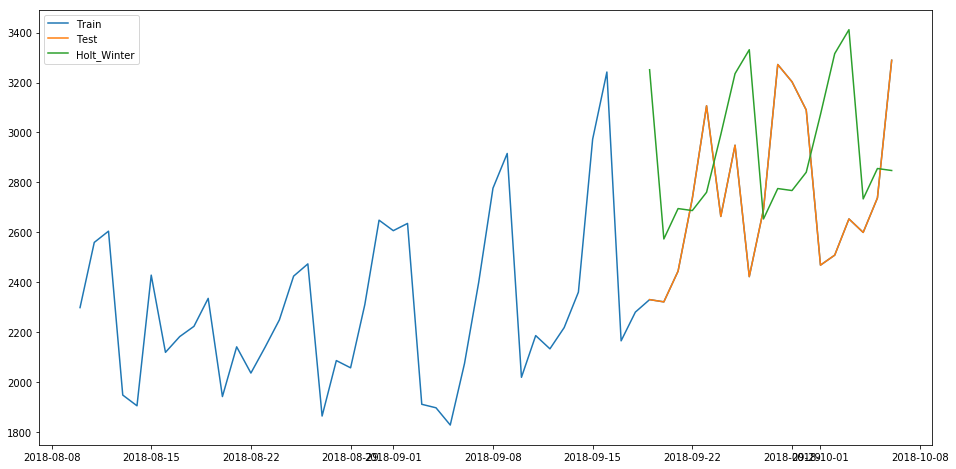

In [248]:
fit1 = ExponentialSmoothing(np.asarray(train.orders) ,seasonal_periods=7 ,trend='add', seasonal='add').fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train.orders, label='Train')
plt.plot(test.orders, label='Test')
plt.plot(y_hat['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [249]:
rms = sqrt(mean_squared_error(test.orders, y_hat.Holt_Winter))
print(rms)

495.7139621019466


### ARIMA

В основе моделей класса ARIMA лежит понятие автокорреляции и плавающего среднего.

<img width = '400px' src="images/lesson_7/arma.png">

$ p(AR(p)): y_{t} - \text {линейная комбинация p предыдущих значений ряда и шумовой компоненты}.$

$ q(MA(q)): y_{t} - \text {линейная комбинация q последних значений шумовой компоненты}.$

ARIMA - линейная модель множественной регрессии, в которой в качестве объяснящих переменных выступают прошлые значения самой зависимой переменной, а в качестве регрессионного остатка - скользящие средние из элементов белого шума.

Для корректного использование модели ARIMA исходный ряд должен быть стационарен.

Проверим это с помощью критерия Дики-Фуллера.

In [250]:
test_ = sm.tsa.adfuller(train.orders)
print ('adf: ', test_[0] )
print ('p-value: ', test_[1])
print('Critical values: ', test_[4])
if test_[0]> test_[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -0.443040098591471
p-value:  0.9026608225128401
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


### Стационарность

Самый частый прием для того, чтобы избавиться от стационарности - провести интегрирование по ряду.

In [274]:
train_diff = train.orders.diff(periods=1).dropna()
train_diff = train_diff.diff(periods=7).dropna()


В коде выше функция diff() вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр period. Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод dropna().

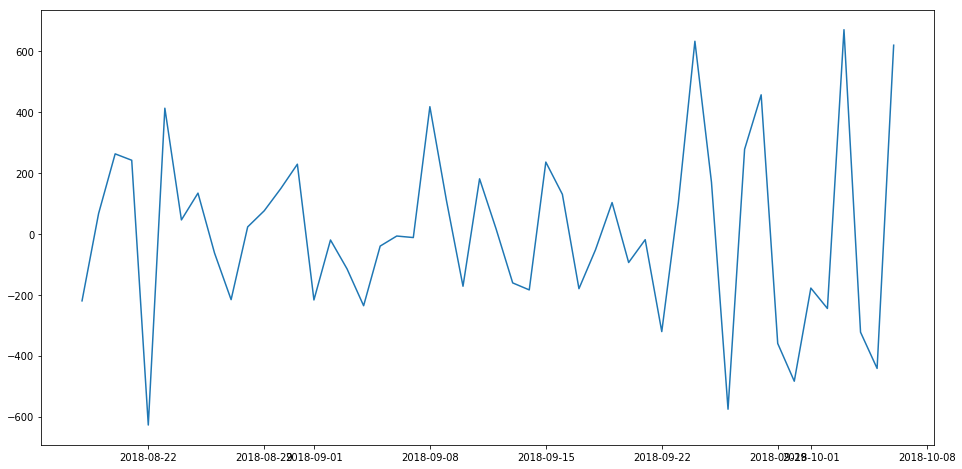

In [275]:
plt.figure(figsize=(16,8))
plt.plot(train_diff, label='Train')
plt.show()

In [276]:
stat_test = sm.tsa.adfuller(train_diff)
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -5.30778973235349
p-value:  5.27583635340386e-06
Critical values:  {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}
единичных корней нет, ряд стационарен


Будем строить модель SARIMA, модель, учитывающая сезонность ряда.

Чтобы построить модель нам нужно знать ее порядок, состоящий из 6-х параметров:

- p,P — порядок компоненты AR
- d,D — порядок интегрированного ряда
- q,Q — порядок компонетны MA

Параметр D равен 1, так как потребовалось делать сезонное дифференцирование.

Для p,P и q,Q надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q и Q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA.
PACF поможет нам определить p и P, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

Подробнее про АКФ и ЧКФ - здесь http://university.prognoz.ru/biu/ru/%D0%90%D0%9A%D0%A4_%D0%B8_%D0%A7%D0%90%D0%9A%D0%A4.

**Автокорреляционная функция** – это зависимость коэффициентов автокорреляции от лага.

**Частная автокорреляционная функция** показывает корреляцию между двумя случайными переменными за вычетом влияния всех внутренних значений автокорреляции. 

<img width = '400px' src="images/lesson_7/partial_autocor.png">

Автокорреляция показывает зависимость между y4 и y1, при этом игнорируя эффект от изменения y2 и y3. А частная автокорреляция также показывает эффект между y4 и y1, при этом учитывая, что эффект от y2 и y3 отсутсвует, то есть убирает эффекты y2 и y3.

Рекомендации к подбору первоначальных приближений:

Q,P - номер последнего сезонного лага при котором автокорреляция значима (персекается граница доверительного интервала).

q,p - номер последнего несезонного лага при котором автокорреляция значима.

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


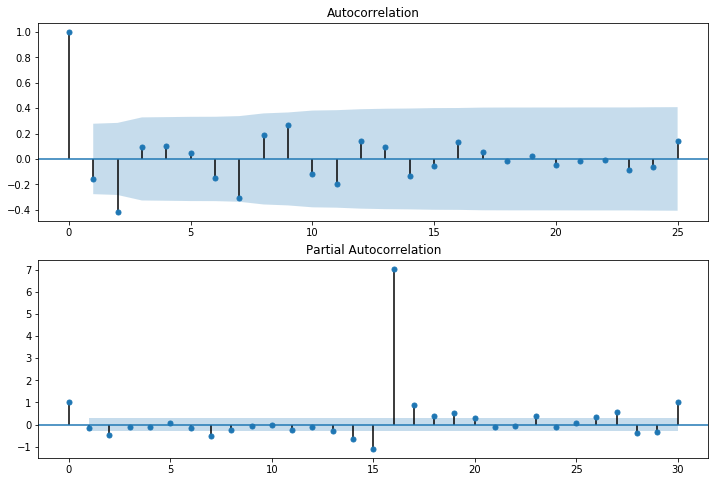

In [277]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_diff, lags=30, ax=ax2)

In [169]:
q = 3
Q = 1

#Q==7 -> Q=1
#Q < 3 q <7

#PACF
p = 9
P = 0


d = 1
D = 1

s = 7


In [170]:
%%time
best_model=sm.tsa.statespace.SARIMAX(train.orders.squeeze(), order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit()

CPU times: user 6.16 s, sys: 10.7 s, total: 16.9 s
Wall time: 2.16 s


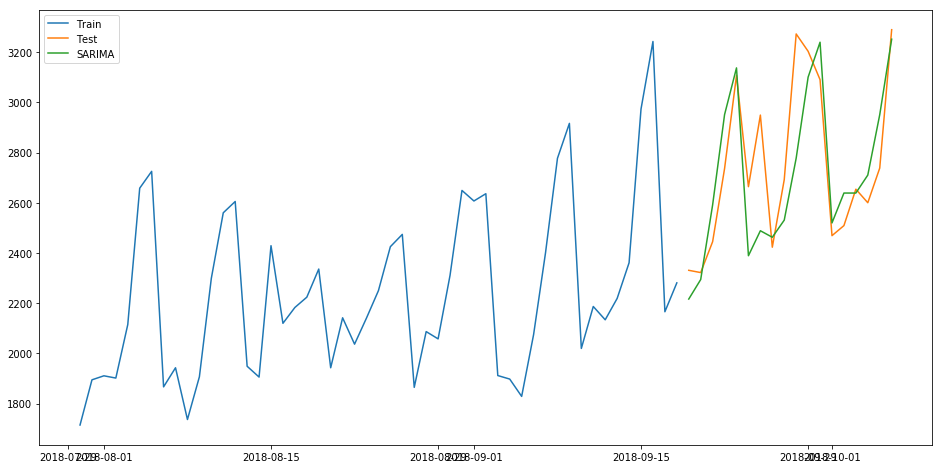

In [171]:
forecast = best_model.predict(start = train.shape[0], end = train.shape[0]+18)
y_hat['SARIMA'] = forecast
plt.figure(figsize=(16,8))
plt.plot(train.orders, label='Train')
plt.plot(test.orders, label='Test')
plt.plot(y_hat['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [172]:
rms = sqrt(mean_squared_error(test.orders, y_hat.SARIMA))
print(rms)

204.54064636156406


In [114]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [187]:
ps = range(1, 6)
ds = 1
qs = range(1, 6)
Ps = range(0, 4)
Ds = 1
Qs = range(0, 3)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

300

In [188]:
%%time
results = []
best_rms = float("inf")
for t in range(40,60,5):
    train = restaurant_orders.sort_values('date', ascending = True).iloc[t:-18]

    for param in tqdm(parameters_list):
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(train.orders.squeeze(), order=(param[0], ds, param[1]), 
                                        seasonal_order=(param[2], Ds, param[3], 7)).fit(disp=-1)
            
            forecast = model.predict(start = train.shape[0], end = train.shape[0]+18)
            y_hat['SARIMA'] = forecast
            rms = sqrt(mean_squared_error(test.orders, y_hat.SARIMA))

            #сохраняем лучшую модель, aic, параметры
            if rms < best_rms:
                best_model = model
                best_rms = rms
                best_param = param
            results.append([t, param, rms])
            #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except Exception:
            print('wrong parameters:', param)
            continue

warnings.filterwarnings('default')





  0%|          | 0/300 [00:00<?, ?it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  0%|          | 1/300 [00:00<00:33,  8.91it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported in

wrong parameters: (1, 1, 0, 0)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  1%|▏         | 4/300 [00:00<00:35,  8.32it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 1, 0)
wrong parameters: (1, 1, 1, 1)
wrong parameters: (1, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  2%|▏         | 7/300 [00:01<00:51,  5.71it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 2, 0)
wrong parameters: (1, 1, 2, 1)
wrong parameters: (1, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  3%|▎         | 10/300 [00:02<01:13,  3.97it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 3, 0)
wrong parameters: (1, 1, 3, 1)
wrong parameters: (1, 1, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  4%|▍         | 13/300 [00:03<00:58,  4.93it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  5%|▌         | 16/300 [00:03<00:59,  4.81it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  6%|▋         | 19/300 [00:04<01:06,  4.24it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (1, 2, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  7%|▋         | 22/300 [00:06<01:30,  3.08it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 3, 0)
wrong parameters: (1, 2, 3, 1)
wrong parameters: (1, 2, 3, 2)
wrong parameters: (1, 3, 0, 0)
wrong parameters: (1, 3, 0, 1)
wrong parameters: (1, 3, 0, 2)
wrong parameters: (1, 3, 1, 0)
wrong parameters: (1, 3, 1, 1)
wrong parameters: (1, 3, 1, 2)
wrong parameters: (1, 3, 2, 0)
wrong parameters: (1, 3, 2, 1)
wrong parameters: (1, 3, 2, 2)
wrong parameters: (1, 3, 3, 0)
wrong parameters: (1, 3, 3, 1)
wrong parameters: (1, 3, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 12%|█▏        | 37/300 [00:06<01:01,  4.28it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 4, 0, 0)
wrong parameters: (1, 4, 0, 1)
wrong parameters: (1, 4, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 13%|█▎        | 40/300 [00:07<01:01,  4.20it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 4, 1, 0)
wrong parameters: (1, 4, 1, 1)
wrong parameters: (1, 4, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 14%|█▍        | 43/300 [00:08<01:06,  3.85it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 4, 2, 0)
wrong parameters: (1, 4, 2, 1)
wrong parameters: (1, 4, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 15%|█▌        | 46/300 [00:10<01:41,  2.51it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 4, 3, 0)
wrong parameters: (1, 4, 3, 1)
wrong parameters: (1, 4, 3, 2)
wrong parameters: (1, 5, 0, 0)
wrong parameters: (1, 5, 0, 1)
wrong parameters: (1, 5, 0, 2)
wrong parameters: (1, 5, 1, 0)
wrong parameters: (1, 5, 1, 1)
wrong parameters: (1, 5, 1, 2)
wrong parameters: (1, 5, 2, 0)
wrong parameters: (1, 5, 2, 1)
wrong parameters: (1, 5, 2, 2)
wrong parameters: (1, 5, 3, 0)
wrong parameters: (1, 5, 3, 1)
wrong parameters: (1, 5, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 20%|██        | 61/300 [00:10<01:07,  3.52it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 21%|██▏       | 64/300 [00:11<00:57,  4.12it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 22%|██▏       | 67/300 [00:11<00:58,  3.96it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 2, 1)
wrong parameters: (2, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 23%|██▎       | 70/300 [00:13<01:28,  2.60it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 29%|██▉       | 88/300 [00:14<00:57,  3.69it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 3, 0)
wrong parameters: (2, 1, 3, 1)
wrong parameters: (2, 1, 3, 2)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 0, 2)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (2, 2, 1, 2)
wrong parameters: (2, 2, 2, 0)
wrong parameters: (2, 2, 2, 1)
wrong parameters: (2, 2, 2, 2)
wrong parameters: (2, 2, 3, 0)
wrong parameters: (2, 2, 3, 1)
wrong parameters: (2, 2, 3, 2)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 0, 1)
wrong parameters: (2, 3, 0, 2)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (2, 3, 1, 1)
wrong parameters: (2, 3, 1, 2)
wrong parameters: (2, 3, 2, 0)
wrong parameters: (2, 3, 2, 1)
wrong parameters: (2, 3, 2, 2)
wrong parameters: (2, 3, 3, 0)
wrong parameters: (2, 3, 3, 1)
wrong parameters: (2, 3, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 32%|███▏      | 97/300 [00:14<00:41,  4.91it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 4, 0, 0)
wrong parameters: (2, 4, 0, 1)
wrong parameters: (2, 4, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 34%|███▍      | 102/300 [00:15<00:40,  4.84it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 4, 1, 0)
wrong parameters: (2, 4, 1, 1)
wrong parameters: (2, 4, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 4, 2, 0)
wrong parameters: (2, 4, 2, 1)
wrong parameters: (2, 4, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 35%|███▌      | 106/300 [00:21<01:51,  1.74it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (2, 4, 3, 0)
wrong parameters: (2, 4, 3, 1)
wrong parameters: (2, 4, 3, 2)
wrong parameters: (2, 5, 0, 0)
wrong parameters: (2, 5, 0, 1)
wrong parameters: (2, 5, 0, 2)
wrong parameters: (2, 5, 1, 0)
wrong parameters: (2, 5, 1, 1)
wrong parameters: (2, 5, 1, 2)
wrong parameters: (2, 5, 2, 0)
wrong parameters: (2, 5, 2, 1)
wrong parameters: (2, 5, 2, 2)
wrong parameters: (2, 5, 3, 0)
wrong parameters: (2, 5, 3, 1)
wrong parameters: (2, 5, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 40%|████      | 121/300 [00:21<01:12,  2.45it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 0, 0)
wrong parameters: (3, 1, 0, 1)
wrong parameters: (3, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 42%|████▏     | 125/300 [00:22<00:58,  2.98it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 1, 0)
wrong parameters: (3, 1, 1, 1)
wrong parameters: (3, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 43%|████▎     | 128/300 [00:23<01:03,  2.72it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 2, 0)
wrong parameters: (3, 1, 2, 1)
wrong parameters: (3, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 43%|████▎     | 130/300 [00:25<01:45,  1.61it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 50%|█████     | 150/300 [00:26<01:05,  2.29it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 3, 0)
wrong parameters: (3, 1, 3, 1)
wrong parameters: (3, 1, 3, 2)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 0, 2)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (3, 2, 1, 2)
wrong parameters: (3, 2, 2, 0)
wrong parameters: (3, 2, 2, 1)
wrong parameters: (3, 2, 2, 2)
wrong parameters: (3, 2, 3, 0)
wrong parameters: (3, 2, 3, 1)
wrong parameters: (3, 2, 3, 2)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 0, 1)
wrong parameters: (3, 3, 0, 2)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 3, 1, 1)
wrong parameters: (3, 3, 1, 2)
wrong parameters: (3, 3, 2, 0)
wrong parameters: (3, 3, 2, 1)
wrong parameters: (3, 3, 2, 2)
wrong parameters: (3, 3, 3, 0)
wrong parameters: (3, 3, 3, 1)
wrong parameters: (3, 3, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 52%|█████▏    | 157/300 [00:26<00:47,  3.01it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (3, 4, 0, 0)
wrong parameters: (3, 4, 0, 1)
wrong parameters: (3, 4, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 4, 1, 0)
wrong parameters: (3, 4, 1, 1)
wrong parameters: (3, 4, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 54%|█████▍    | 163/300 [00:30<00:55,  2.45it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (3, 4, 2, 0)
wrong parameters: (3, 4, 2, 1)
wrong parameters: (3, 4, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 56%|█████▌    | 167/300 [00:33<01:15,  1.76it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (3, 4, 3, 0)
wrong parameters: (3, 4, 3, 1)
wrong parameters: (3, 4, 3, 2)
wrong parameters: (3, 5, 0, 0)
wrong parameters: (3, 5, 0, 1)
wrong parameters: (3, 5, 0, 2)
wrong parameters: (3, 5, 1, 0)
wrong parameters: (3, 5, 1, 1)
wrong parameters: (3, 5, 1, 2)
wrong parameters: (3, 5, 2, 0)
wrong parameters: (3, 5, 2, 1)
wrong parameters: (3, 5, 2, 2)
wrong parameters: (3, 5, 3, 0)
wrong parameters: (3, 5, 3, 1)
wrong parameters: (3, 5, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 60%|██████    | 181/300 [00:34<00:48,  2.47it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 0, 0)
wrong parameters: (4, 1, 0, 1)
wrong parameters: (4, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 62%|██████▏   | 185/300 [00:35<00:39,  2.88it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 1, 0)
wrong parameters: (4, 1, 1, 1)
wrong parameters: (4, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 63%|██████▎   | 188/300 [00:36<00:43,  2.57it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 2, 0)
wrong parameters: (4, 1, 2, 1)
wrong parameters: (4, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 63%|██████▎   | 190/300 [00:39<01:17,  1.42it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 70%|███████   | 211/300 [00:39<00:43,  2.03it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 3, 0)
wrong parameters: (4, 1, 3, 1)
wrong parameters: (4, 1, 3, 2)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 0, 2)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
wrong parameters: (4, 2, 1, 2)
wrong parameters: (4, 2, 2, 0)
wrong parameters: (4, 2, 2, 1)
wrong parameters: (4, 2, 2, 2)
wrong parameters: (4, 2, 3, 0)
wrong parameters: (4, 2, 3, 1)
wrong parameters: (4, 2, 3, 2)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 0, 1)
wrong parameters: (4, 3, 0, 2)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (4, 3, 1, 1)
wrong parameters: (4, 3, 1, 2)
wrong parameters: (4, 3, 2, 0)
wrong parameters: (4, 3, 2, 1)
wrong parameters: (4, 3, 2, 2)
wrong parameters: (4, 3, 3, 0)
wrong parameters: (4, 3, 3, 1)
wrong parameters: (4, 3, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 73%|███████▎  | 218/300 [00:40<00:30,  2.66it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 0, 1)
wrong parameters: (4, 4, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 4, 1, 0)
wrong parameters: (4, 4, 1, 1)
wrong parameters: (4, 4, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 75%|███████▍  | 224/300 [00:44<00:36,  2.09it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (4, 4, 2, 0)
wrong parameters: (4, 4, 2, 1)
wrong parameters: (4, 4, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 76%|███████▌  | 228/300 [00:49<00:50,  1.42it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (4, 4, 3, 0)
wrong parameters: (4, 4, 3, 1)
wrong parameters: (4, 4, 3, 2)
wrong parameters: (4, 5, 0, 0)
wrong parameters: (4, 5, 0, 1)
wrong parameters: (4, 5, 0, 2)
wrong parameters: (4, 5, 1, 0)
wrong parameters: (4, 5, 1, 1)
wrong parameters: (4, 5, 1, 2)
wrong parameters: (4, 5, 2, 0)
wrong parameters: (4, 5, 2, 1)
wrong parameters: (4, 5, 2, 2)
wrong parameters: (4, 5, 3, 0)
wrong parameters: (4, 5, 3, 1)
wrong parameters: (4, 5, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 80%|████████  | 241/300 [00:49<00:29,  1.99it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 1, 0, 0)
wrong parameters: (5, 1, 0, 1)
wrong parameters: (5, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 81%|████████▏ | 244/300 [00:50<00:25,  2.22it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 1, 1, 0)
wrong parameters: (5, 1, 1, 1)
wrong parameters: (5, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 82%|████████▏ | 247/300 [00:53<00:29,  1.81it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 1, 2, 0)
wrong parameters: (5, 1, 2, 1)
wrong parameters: (5, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 83%|████████▎ | 250/300 [00:58<00:45,  1.09it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 89%|████████▉ | 267/300 [00:58<00:21,  1.55it/s]



100%|██████████| 300/300 [00:58<00:00,  5.11it/s]



  0%|          | 0/300 [00:00<?, ?it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 1, 3, 0)
wrong parameters: (5, 1, 3, 1)
wrong parameters: (5, 1, 3, 2)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 0, 1)
wrong parameters: (5, 2, 0, 2)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 2, 1, 1)
wrong parameters: (5, 2, 1, 2)
wrong parameters: (5, 2, 2, 0)
wrong parameters: (5, 2, 2, 1)
wrong parameters: (5, 2, 2, 2)
wrong parameters: (5, 2, 3, 0)
wrong parameters: (5, 2, 3, 1)
wrong parameters: (5, 2, 3, 2)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 0, 1)
wrong parameters: (5, 3, 0, 2)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 3, 1, 1)
wrong parameters: (5, 3, 1, 2)
wrong parameters: (5, 3, 2, 0)
wrong parameters: (5, 3, 2, 1)
wrong parameters: (5, 3, 2, 2)
wrong parameters: (5, 3, 3, 0)
wrong parameters: (5, 3, 3, 1)
wrong parameters: (5, 3, 3, 2)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 0, 1)
wrong parameters: (5, 4, 0, 2)
wrong parameters: (5, 4, 1, 0)
wrong parameters: (5, 4, 1, 1)
wrong pa

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 0, 0)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  1%|▏         | 4/300 [00:00<00:28, 10.42it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  2%|▏         | 5/300 [00:00<00:52,  5.64it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 1, 1)
wrong parameters: (1, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  2%|▏         | 7/300 [00:01<01:20,  3.64it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  3%|▎         | 8/300 [00:02<02:09,  2.25it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 2, 1)
wrong parameters: (1, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  3%|▎         | 10/300 [00:04<02:32,  1.90it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  4%|▎         | 11/300 [00:05<04:07,  1.17it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 3, 1)
wrong parameters: (1, 1, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  4%|▍         | 13/300 [00:05<03:02,  1.57it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  5%|▌         | 16/300 [00:06<02:16,  2.08it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  6%|▌         | 17/300 [00:07<02:44,  1.72it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  6%|▋         | 19/300 [00:07<02:28,  1.89it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  7%|▋         | 20/300 [00:09<03:38,  1.28it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (1, 2, 2, 1)
wrong parameters: (1, 2, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  7%|▋         | 22/300 [00:11<04:02,  1.15it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  8%|▊         | 23/300 [00:14<07:25,  1.61s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (1, 2, 3, 1)
wrong parameters: (1, 2, 3, 2)
wrong parameters: (1, 3, 0, 0)
wrong parameters: (1, 3, 0, 1)
wrong parameters: (1, 3, 0, 2)
wrong parameters: (1, 3, 1, 0)
wrong parameters: (1, 3, 1, 1)
wrong parameters: (1, 3, 1, 2)
wrong parameters: (1, 3, 2, 0)
wrong parameters: (1, 3, 2, 1)
wrong parameters: (1, 3, 2, 2)
wrong parameters: (1, 3, 3, 0)
wrong parameters: (1, 3, 3, 1)
wrong parameters: (1, 3, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 12%|█▏        | 37/300 [00:15<04:57,  1.13s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 4, 0, 0)
wrong parameters: (1, 4, 0, 1)
wrong parameters: (1, 4, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 13%|█▎        | 40/300 [00:15<03:41,  1.17it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 4, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 14%|█▍        | 42/300 [00:16<03:18,  1.30it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 4, 1, 1)
wrong parameters: (1, 4, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 14%|█▍        | 43/300 [00:18<04:01,  1.06it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 4, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 15%|█▍        | 44/300 [00:19<04:47,  1.12s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (1, 4, 2, 1)
wrong parameters: (1, 4, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 15%|█▌        | 46/300 [00:21<04:46,  1.13s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 4, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 16%|█▌        | 47/300 [00:25<07:10,  1.70s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (1, 4, 3, 1)
wrong parameters: (1, 4, 3, 2)
wrong parameters: (1, 5, 0, 0)
wrong parameters: (1, 5, 0, 1)
wrong parameters: (1, 5, 0, 2)
wrong parameters: (1, 5, 1, 0)
wrong parameters: (1, 5, 1, 1)
wrong parameters: (1, 5, 1, 2)
wrong parameters: (1, 5, 2, 0)
wrong parameters: (1, 5, 2, 1)
wrong parameters: (1, 5, 2, 2)
wrong parameters: (1, 5, 3, 0)
wrong parameters: (1, 5, 3, 1)
wrong parameters: (1, 5, 3, 2)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 21%|██▏       | 64/300 [00:25<03:26,  1.14it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when 

wrong parameters: (2, 1, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 22%|██▏       | 66/300 [00:26<02:52,  1.36it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 23%|██▎       | 68/300 [00:28<03:07,  1.24it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 2, 1)
wrong parameters: (2, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 23%|██▎       | 70/300 [00:29<02:58,  1.29it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 24%|██▎       | 71/300 [00:31<04:29,  1.18s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 29%|██▉       | 87/300 [00:31<02:55,  1.21it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 3, 1)
wrong parameters: (2, 1, 3, 2)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 0, 2)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (2, 2, 1, 2)
wrong parameters: (2, 2, 2, 0)
wrong parameters: (2, 2, 2, 1)
wrong parameters: (2, 2, 2, 2)
wrong parameters: (2, 2, 3, 0)
wrong parameters: (2, 2, 3, 1)
wrong parameters: (2, 2, 3, 2)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 0, 1)
wrong parameters: (2, 3, 0, 2)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (2, 3, 1, 1)
wrong parameters: (2, 3, 1, 2)
wrong parameters: (2, 3, 2, 0)
wrong parameters: (2, 3, 2, 1)
wrong parameters: (2, 3, 2, 2)
wrong parameters: (2, 3, 3, 0)
wrong parameters: (2, 3, 3, 1)
wrong parameters: (2, 3, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 32%|███▏      | 97/300 [00:32<02:00,  1.69it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (2, 4, 0, 0)
wrong parameters: (2, 4, 0, 1)
wrong parameters: (2, 4, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 4, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 34%|███▍      | 102/300 [00:34<01:49,  1.81it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (2, 4, 1, 1)
wrong parameters: (2, 4, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 4, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 4, 2, 1)
wrong parameters: (2, 4, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 35%|███▌      | 106/300 [00:42<03:10,  1.02it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (2, 4, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 36%|███▋      | 109/300 [00:46<03:21,  1.06s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (2, 4, 3, 1)
wrong parameters: (2, 4, 3, 2)
wrong parameters: (2, 5, 0, 0)
wrong parameters: (2, 5, 0, 1)
wrong parameters: (2, 5, 0, 2)
wrong parameters: (2, 5, 1, 0)
wrong parameters: (2, 5, 1, 1)
wrong parameters: (2, 5, 1, 2)
wrong parameters: (2, 5, 2, 0)
wrong parameters: (2, 5, 2, 1)
wrong parameters: (2, 5, 2, 2)
wrong parameters: (2, 5, 3, 0)
wrong parameters: (2, 5, 3, 1)
wrong parameters: (2, 5, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 40%|████      | 121/300 [00:46<02:13,  1.34it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 0, 0)
wrong parameters: (3, 1, 0, 1)
wrong parameters: (3, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 41%|████▏     | 124/300 [00:47<01:40,  1.75it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 1, 1)
wrong parameters: (3, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 42%|████▏     | 127/300 [00:48<01:38,  1.75it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 43%|████▎     | 129/300 [00:50<01:45,  1.62it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 2, 1)
wrong parameters: (3, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 44%|████▎     | 131/300 [00:54<03:13,  1.14s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 51%|█████     | 153/300 [00:55<01:57,  1.25it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 3, 1)
wrong parameters: (3, 1, 3, 2)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 0, 2)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (3, 2, 1, 2)
wrong parameters: (3, 2, 2, 0)
wrong parameters: (3, 2, 2, 1)
wrong parameters: (3, 2, 2, 2)
wrong parameters: (3, 2, 3, 0)
wrong parameters: (3, 2, 3, 1)
wrong parameters: (3, 2, 3, 2)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 0, 1)
wrong parameters: (3, 3, 0, 2)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 3, 1, 1)
wrong parameters: (3, 3, 1, 2)
wrong parameters: (3, 3, 2, 0)
wrong parameters: (3, 3, 2, 1)
wrong parameters: (3, 3, 2, 2)
wrong parameters: (3, 3, 3, 0)
wrong parameters: (3, 3, 3, 1)
wrong parameters: (3, 3, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 4, 0, 0)
wrong parameters: (3, 4, 0, 1)
wrong parameters: (3, 4, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 53%|█████▎    | 160/300 [00:56<01:28,  1.58it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (3, 4, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 4, 1, 1)
wrong parameters: (3, 4, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 4, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 55%|█████▌    | 165/300 [01:02<01:46,  1.27it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (3, 4, 2, 1)
wrong parameters: (3, 4, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 4, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 56%|█████▋    | 169/300 [01:10<02:25,  1.11s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (3, 4, 3, 1)
wrong parameters: (3, 4, 3, 2)
wrong parameters: (3, 5, 0, 0)
wrong parameters: (3, 5, 0, 1)
wrong parameters: (3, 5, 0, 2)
wrong parameters: (3, 5, 1, 0)
wrong parameters: (3, 5, 1, 1)
wrong parameters: (3, 5, 1, 2)
wrong parameters: (3, 5, 2, 0)
wrong parameters: (3, 5, 2, 1)
wrong parameters: (3, 5, 2, 2)
wrong parameters: (3, 5, 3, 0)
wrong parameters: (3, 5, 3, 1)
wrong parameters: (3, 5, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 60%|██████    | 181/300 [01:10<01:33,  1.27it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 0, 0)
wrong parameters: (4, 1, 0, 1)
wrong parameters: (4, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 62%|██████▏   | 185/300 [01:12<01:18,  1.47it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 1, 1)
wrong parameters: (4, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 63%|██████▎   | 188/300 [01:15<01:33,  1.19it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (4, 1, 2, 1)
wrong parameters: (4, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 63%|██████▎   | 190/300 [01:18<01:59,  1.08s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 64%|██████▍   | 192/300 [01:22<02:23,  1.33s/it]



 67%|██████▋   | 202/300 [01:22<01:31,  1.07it/s]

wrong parameters: (4, 1, 3, 1)
wrong parameters: (4, 1, 3, 2)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 0, 2)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
wrong parameters: (4, 2, 1, 2)
wrong parameters: (4, 2, 2, 0)
wrong parameters: (4, 2, 2, 1)
wrong parameters: (4, 2, 2, 2)
wrong parameters: (4, 2, 3, 0)
wrong parameters: (4, 2, 3, 1)
wrong parameters: (4, 2, 3, 2)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 0, 1)
wrong parameters: (4, 3, 0, 2)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (4, 3, 1, 1)
wrong parameters: (4, 3, 1, 2)
wrong parameters: (4, 3, 2, 0)
wrong parameters: (4, 3, 2, 1)
wrong parameters: (4, 3, 2, 2)
wrong parameters: (4, 3, 3, 0)
wrong parameters: (4, 3, 3, 1)
wrong parameters: (4, 3, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 72%|███████▏  | 217/300 [01:23<00:54,  1.51it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting

wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 0, 1)
wrong parameters: (4, 4, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 4, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 74%|███████▎  | 221/300 [01:26<00:53,  1.47it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (4, 4, 1, 1)
wrong parameters: (4, 4, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 4, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 75%|███████▍  | 224/300 [01:31<01:15,  1.01it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (4, 4, 2, 1)
wrong parameters: (4, 4, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 75%|███████▌  | 226/300 [01:36<01:47,  1.45s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (4, 4, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 76%|███████▌  | 228/300 [01:41<02:07,  1.77s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (4, 4, 3, 1)
wrong parameters: (4, 4, 3, 2)
wrong parameters: (4, 5, 0, 0)
wrong parameters: (4, 5, 0, 1)
wrong parameters: (4, 5, 0, 2)
wrong parameters: (4, 5, 1, 0)
wrong parameters: (4, 5, 1, 1)
wrong parameters: (4, 5, 1, 2)
wrong parameters: (4, 5, 2, 0)
wrong parameters: (4, 5, 2, 1)
wrong parameters: (4, 5, 2, 2)
wrong parameters: (4, 5, 3, 0)
wrong parameters: (4, 5, 3, 1)
wrong parameters: (4, 5, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 80%|████████  | 241/300 [01:41<01:13,  1.25s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 1, 0, 0)
wrong parameters: (5, 1, 0, 1)
wrong parameters: (5, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 81%|████████▏ | 244/300 [01:42<00:53,  1.04it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 1, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 82%|████████▏ | 246/300 [01:43<00:46,  1.16it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 1, 1, 1)
wrong parameters: (5, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 82%|████████▏ | 247/300 [01:45<01:03,  1.19s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 1, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 83%|████████▎ | 248/300 [01:48<01:23,  1.61s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 1, 2, 1)
wrong parameters: (5, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 83%|████████▎ | 250/300 [01:51<01:21,  1.62s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 1, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 84%|████████▎ | 251/300 [01:56<01:58,  2.42s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 1, 3, 1)
wrong parameters: (5, 1, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 84%|████████▍ | 253/300 [01:56<01:22,  1.76s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 0, 1)
wrong parameters: (5, 2, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 85%|████████▌ | 256/300 [01:57<00:59,  1.36s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 2, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 86%|████████▌ | 257/300 [01:59<01:02,  1.44s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 2, 1, 1)
wrong parameters: (5, 2, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 86%|████████▋ | 259/300 [02:02<00:58,  1.43s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 2, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 87%|████████▋ | 260/300 [02:05<01:13,  1.85s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 2, 2, 1)
wrong parameters: (5, 2, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 87%|████████▋ | 262/300 [02:09<01:15,  1.99s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 2, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 88%|████████▊ | 263/300 [02:15<01:53,  3.07s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 2, 3, 1)
wrong parameters: (5, 2, 3, 2)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 0, 1)
wrong parameters: (5, 3, 0, 2)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 3, 1, 1)
wrong parameters: (5, 3, 1, 2)
wrong parameters: (5, 3, 2, 0)
wrong parameters: (5, 3, 2, 1)
wrong parameters: (5, 3, 2, 2)
wrong parameters: (5, 3, 3, 0)
wrong parameters: (5, 3, 3, 1)
wrong parameters: (5, 3, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 92%|█████████▏| 277/300 [02:15<00:49,  2.16s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 0, 1)
wrong parameters: (5, 4, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 93%|█████████▎| 280/300 [02:17<00:33,  1.66s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 4, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 94%|█████████▎| 281/300 [02:19<00:31,  1.65s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 4, 1, 1)
wrong parameters: (5, 4, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 94%|█████████▍| 283/300 [02:22<00:27,  1.61s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 4, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 95%|█████████▍| 284/300 [02:25<00:33,  2.12s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 4, 2, 1)
wrong parameters: (5, 4, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 95%|█████████▌| 286/300 [02:30<00:32,  2.30s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (5, 4, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 96%|█████████▌| 287/300 [02:36<00:45,  3.47s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




100%|██████████| 300/300 [02:37<00:00,  1.91it/s]



  0%|          | 0/300 [00:00<?, ?it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, bu

wrong parameters: (5, 4, 3, 1)
wrong parameters: (5, 4, 3, 2)
wrong parameters: (5, 5, 0, 0)
wrong parameters: (5, 5, 0, 1)
wrong parameters: (5, 5, 0, 2)
wrong parameters: (5, 5, 1, 0)
wrong parameters: (5, 5, 1, 1)
wrong parameters: (5, 5, 1, 2)
wrong parameters: (5, 5, 2, 0)
wrong parameters: (5, 5, 2, 1)
wrong parameters: (5, 5, 2, 2)
wrong parameters: (5, 5, 3, 0)
wrong parameters: (5, 5, 3, 1)
wrong parameters: (5, 5, 3, 2)
wrong parameters: (1, 1, 0, 0)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:

wrong parameters: (1, 1, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  2%|▏         | 5/300 [00:01<01:16,  3.87it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 1, 1, 1)
wrong parameters: (1, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  2%|▏         | 7/300 [00:01<01:17,  3.78it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of a

wrong parameters: (1, 1, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  3%|▎         | 8/300 [00:02<02:42,  1.80it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty

wrong parameters: (1, 1, 2, 1)
wrong parameters: (1, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  3%|▎         | 10/300 [00:04<03:20,  1.44it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: 

wrong parameters: (1, 1, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  4%|▎         | 11/300 [00:07<05:59,  1.25s/it]

wrong parameters: (1, 1, 3, 1)
wrong parameters: (1, 1, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  4%|▍         | 13/300 [00:07<04:19,  1.11it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when 

wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  5%|▌         | 16/300 [00:08<03:15,  1.45it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of 

wrong parameters: (1, 2, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  6%|▌         | 17/300 [00:08<03:23,  1.39it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  6%|▋         | 19/300 [00:09<02:52,  1.63it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of 

wrong parameters: (1, 2, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  7%|▋         | 20/300 [00:11<04:00,  1.16it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (1, 2, 2, 1)
wrong parameters: (1, 2, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  7%|▋         | 22/300 [00:12<03:39,  1.27it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of 

wrong parameters: (1, 2, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  8%|▊         | 23/300 [00:14<05:21,  1.16s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 3, 1)
wrong parameters: (1, 2, 3, 2)
wrong parameters: (1, 3, 0, 0)
wrong parameters: (1, 3, 0, 1)
wrong parameters: (1, 3, 0, 2)
wrong parameters: (1, 3, 1, 0)
wrong parameters: (1, 3, 1, 1)
wrong parameters: (1, 3, 1, 2)
wrong parameters: (1, 3, 2, 0)
wrong parameters: (1, 3, 2, 1)
wrong parameters: (1, 3, 2, 2)
wrong parameters: (1, 3, 3, 0)
wrong parameters: (1, 3, 3, 1)
wrong parameters: (1, 3, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 12%|█▏        | 37/300 [00:14<03:36,  1.22it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: 

wrong parameters: (1, 4, 0, 0)
wrong parameters: (1, 4, 0, 1)
wrong parameters: (1, 4, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 13%|█▎        | 40/300 [00:15<02:51,  1.51it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: 

wrong parameters: (1, 4, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 14%|█▎        | 41/300 [00:17<03:39,  1.18it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (1, 4, 1, 1)
wrong parameters: (1, 4, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 14%|█▍        | 43/300 [00:18<03:33,  1.20it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: 

wrong parameters: (1, 4, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 15%|█▍        | 44/300 [00:20<04:43,  1.11s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (1, 4, 2, 1)
wrong parameters: (1, 4, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 15%|█▌        | 46/300 [00:23<05:00,  1.18s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: 

wrong parameters: (1, 4, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 16%|█▌        | 47/300 [00:25<07:02,  1.67s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (1, 4, 3, 1)
wrong parameters: (1, 4, 3, 2)
wrong parameters: (1, 5, 0, 0)
wrong parameters: (1, 5, 0, 1)
wrong parameters: (1, 5, 0, 2)
wrong parameters: (1, 5, 1, 0)
wrong parameters: (1, 5, 1, 1)
wrong parameters: (1, 5, 1, 2)
wrong parameters: (1, 5, 2, 0)
wrong parameters: (1, 5, 2, 1)
wrong parameters: (1, 5, 2, 2)
wrong parameters: (1, 5, 3, 0)
wrong parameters: (1, 5, 3, 1)
wrong parameters: (1, 5, 3, 2)
wrong parameters: (2, 1, 0, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 21%|██▏       | 64/300 [00:26<03:24,  1.15it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of 

wrong parameters: (2, 1, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 22%|██▏       | 66/300 [00:27<02:50,  1.37it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

wrong parameters: (2, 1, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 23%|██▎       | 68/300 [00:29<03:07,  1.24it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (2, 1, 2, 1)
wrong parameters: (2, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 23%|██▎       | 70/300 [00:32<03:47,  1.01it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: 

wrong parameters: (2, 1, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 24%|██▎       | 71/300 [00:35<05:55,  1.55s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (2, 1, 3, 1)
wrong parameters: (2, 1, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 24%|██▍       | 73/300 [00:35<04:15,  1.12s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of 

wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 25%|██▌       | 76/300 [00:35<03:11,  1.17it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of 

wrong parameters: (2, 2, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 26%|██▌       | 77/300 [00:36<03:05,  1.21it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 2, 1, 1)
wrong parameters: (2, 2, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 26%|██▋       | 79/300 [00:38<03:00,  1.22it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of 

wrong parameters: (2, 2, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 27%|██▋       | 80/300 [00:39<03:58,  1.08s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

wrong parameters: (2, 2, 2, 1)
wrong parameters: (2, 2, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 27%|██▋       | 82/300 [00:41<03:44,  1.03s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of 

wrong parameters: (2, 2, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 28%|██▊       | 83/300 [00:44<05:41,  1.58s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 34%|███▍      | 102/300 [00:44<03:38,  1.10s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 2, 3, 1)
wrong parameters: (2, 2, 3, 2)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 0, 1)
wrong parameters: (2, 3, 0, 2)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (2, 3, 1, 1)
wrong parameters: (2, 3, 1, 2)
wrong parameters: (2, 3, 2, 0)
wrong parameters: (2, 3, 2, 1)
wrong parameters: (2, 3, 2, 2)
wrong parameters: (2, 3, 3, 0)
wrong parameters: (2, 3, 3, 1)
wrong parameters: (2, 3, 3, 2)
wrong parameters: (2, 4, 0, 0)
wrong parameters: (2, 4, 0, 1)
wrong parameters: (2, 4, 0, 2)
wrong parameters: (2, 4, 1, 0)
wrong parameters: (2, 4, 1, 1)
wrong parameters: (2, 4, 1, 2)
wrong parameters: (2, 4, 2, 0)
wrong parameters: (2, 4, 2, 1)
wrong parameters: (2, 4, 2, 2)
wrong parameters: (2, 4, 3, 0)
wrong parameters: (2, 4, 3, 1)
wrong parameters: (2, 4, 3, 2)
wrong parameters: (2, 5, 0, 0)
wrong parameters: (2, 5, 0, 1)
wrong parameters: (2, 5, 0, 2)
wrong parameters: (2, 5, 1, 0)
wrong parameters: (2, 5, 1, 1)
wrong parameters: (2, 5, 1, 2)
wrong pa

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 40%|████      | 121/300 [00:44<02:18,  1.29it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of

wrong parameters: (3, 1, 0, 0)
wrong parameters: (3, 1, 0, 1)
wrong parameters: (3, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

wrong parameters: (3, 1, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 1, 1)
wrong parameters: (3, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

wrong parameters: (3, 1, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 43%|████▎     | 128/300 [00:49<02:09,  1.33it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp

wrong parameters: (3, 1, 2, 1)
wrong parameters: (3, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

wrong parameters: (3, 1, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 44%|████▍     | 133/300 [00:56<02:30,  1.11it/s]



 51%|█████▏    | 154/300 [00:56<01:32,  1.58it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

wrong parameters: (3, 1, 3, 1)
wrong parameters: (3, 1, 3, 2)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 0, 2)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (3, 2, 1, 2)
wrong parameters: (3, 2, 2, 0)
wrong parameters: (3, 2, 2, 1)
wrong parameters: (3, 2, 2, 2)
wrong parameters: (3, 2, 3, 0)
wrong parameters: (3, 2, 3, 1)
wrong parameters: (3, 2, 3, 2)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 0, 1)
wrong parameters: (3, 3, 0, 2)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 3, 1, 1)
wrong parameters: (3, 3, 1, 2)
wrong parameters: (3, 3, 2, 0)
wrong parameters: (3, 3, 2, 1)
wrong parameters: (3, 3, 2, 2)
wrong parameters: (3, 3, 3, 0)
wrong parameters: (3, 3, 3, 1)
wrong parameters: (3, 3, 3, 2)
wrong parameters: (3, 4, 0, 0)
wrong parameters: (3, 4, 0, 1)
wrong parameters: (3, 4, 0, 2)
wrong parameters: (3, 4, 1, 0)
wrong parameters: (3, 4, 1, 1)
wrong parameters: (3, 4, 1, 2)
wrong pa

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 60%|██████    | 181/300 [00:56<00:53,  2.24it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of

wrong parameters: (4, 1, 0, 0)
wrong parameters: (4, 1, 0, 1)
wrong parameters: (4, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

wrong parameters: (4, 1, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 1, 1)
wrong parameters: (4, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

wrong parameters: (4, 1, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 2, 1)
wrong parameters: (4, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 63%|██████▎   | 190/300 [01:04<01:03,  1.74it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of

wrong parameters: (4, 1, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 66%|██████▌   | 197/300 [01:07<00:57,  1.79it/s]



 72%|███████▏  | 217/300 [01:08<00:32,  2.55it/s]

wrong parameters: (4, 1, 3, 1)
wrong parameters: (4, 1, 3, 2)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 0, 2)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
wrong parameters: (4, 2, 1, 2)
wrong parameters: (4, 2, 2, 0)
wrong parameters: (4, 2, 2, 1)
wrong parameters: (4, 2, 2, 2)
wrong parameters: (4, 2, 3, 0)
wrong parameters: (4, 2, 3, 1)
wrong parameters: (4, 2, 3, 2)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 0, 1)
wrong parameters: (4, 3, 0, 2)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (4, 3, 1, 1)
wrong parameters: (4, 3, 1, 2)
wrong parameters: (4, 3, 2, 0)
wrong parameters: (4, 3, 2, 1)
wrong parameters: (4, 3, 2, 2)
wrong parameters: (4, 3, 3, 0)
wrong parameters: (4, 3, 3, 1)
wrong parameters: (4, 3, 3, 2)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 0, 1)
wrong parameters: (4, 4, 0, 2)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (4, 4, 1, 1)
wrong parameters: (4, 4, 1, 2)
wrong pa

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 80%|████████  | 241/300 [01:08<00:16,  3.59it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[

wrong parameters: (5, 1, 0, 0)
wrong parameters: (5, 1, 0, 1)
wrong parameters: (5, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

wrong parameters: (5, 1, 1, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 1, 1, 1)
wrong parameters: (5, 1, 1, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

wrong parameters: (5, 1, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 1, 2, 1)
wrong parameters: (5, 1, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 83%|████████▎ | 250/300 [01:18<00:26,  1.86it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning:

wrong parameters: (5, 1, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 84%|████████▎ | 251/300 [01:22<01:18,  1.60s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 90%|████████▉ | 269/300 [01:22<00:34,  1.12s/it]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

wrong parameters: (5, 1, 3, 1)
wrong parameters: (5, 1, 3, 2)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 0, 1)
wrong parameters: (5, 2, 0, 2)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 2, 1, 1)
wrong parameters: (5, 2, 1, 2)
wrong parameters: (5, 2, 2, 0)
wrong parameters: (5, 2, 2, 1)
wrong parameters: (5, 2, 2, 2)
wrong parameters: (5, 2, 3, 0)
wrong parameters: (5, 2, 3, 1)
wrong parameters: (5, 2, 3, 2)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 0, 1)
wrong parameters: (5, 3, 0, 2)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 3, 1, 1)
wrong parameters: (5, 3, 1, 2)
wrong parameters: (5, 3, 2, 0)
wrong parameters: (5, 3, 2, 1)
wrong parameters: (5, 3, 2, 2)
wrong parameters: (5, 3, 3, 0)
wrong parameters: (5, 3, 3, 1)
wrong parameters: (5, 3, 3, 2)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 0, 1)
wrong parameters: (5, 4, 0, 2)
wrong parameters: (5, 4, 1, 0)
wrong parameters: (5, 4, 1, 1)
wrong parameters: (5, 4, 1, 2)
wrong pa

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




 97%|█████████▋| 291/300 [01:22<00:07,  1.27it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


 (5, 5, 0, 2)
wrong parameters: (5, 5, 1, 0)
wrong parameters: (5, 5, 1, 1)
wrong parameters: (5, 5, 1, 2)
wrong parameters: (5, 5, 2, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:202: RuntimeWarning: overflow encountered in true_divide
  for i, ih in enumerate(increments)]
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (5, 5, 2, 1)
wrong parameters: (5, 5, 2, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:202: RuntimeWarning: overflow encountered in true_divide
  for i, ih in enumerate(increments)]
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgen

wrong parameters: (5, 5, 3, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




100%|██████████| 300/300 [01:25<00:00,  3.51it/s]



  0%|          | 0/300 [00:00<?, ?it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported in

wrong parameters: (5, 5, 3, 1)
wrong parameters: (5, 5, 3, 2)
wrong parameters: (1, 1, 0, 0)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  1%|▏         | 4/300 [00:00<00:38,  7.62it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be 

wrong parameters: (1, 1, 1, 0)
wrong parameters: (1, 1, 1, 1)
wrong parameters: (1, 1, 1, 2)
wrong parameters: (1, 1, 2, 0)
wrong parameters: (1, 1, 2, 1)
wrong parameters: (1, 1, 2, 2)
wrong parameters: (1, 1, 3, 0)
wrong parameters: (1, 1, 3, 1)
wrong parameters: (1, 1, 3, 2)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (1, 2, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




  5%|▌         | 16/300 [00:01<00:31,  9.08it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 11%|█▏        | 34/300 [00:01<00:20, 12.69it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sari

wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 1, 2)
wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (1, 2, 2, 2)
wrong parameters: (1, 2, 3, 0)
wrong parameters: (1, 2, 3, 1)
wrong parameters: (1, 2, 3, 2)
wrong parameters: (1, 3, 0, 0)
wrong parameters: (1, 3, 0, 1)
wrong parameters: (1, 3, 0, 2)
wrong parameters: (1, 3, 1, 0)
wrong parameters: (1, 3, 1, 1)
wrong parameters: (1, 3, 1, 2)
wrong parameters: (1, 3, 2, 0)
wrong parameters: (1, 3, 2, 1)
wrong parameters: (1, 3, 2, 2)
wrong parameters: (1, 3, 3, 0)
wrong parameters: (1, 3, 3, 1)
wrong parameters: (1, 3, 3, 2)
wrong parameters: (1, 4, 0, 0)
wrong parameters: (1, 4, 0, 1)
wrong parameters: (1, 4, 0, 2)
wrong parameters: (1, 4, 1, 0)
wrong parameters: (1, 4, 1, 1)
wrong parameters: (1, 4, 1, 2)
wrong parameters: (1, 4, 2, 0)
wrong parameters: (1, 4, 2, 1)
wrong parameters: (1, 4, 2, 2)
wrong parameters: (1, 4, 3, 0)
wrong parameters: (1, 4, 3, 1)
wrong pa

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)




 20%|██        | 61/300 [00:01<00:13, 17.56it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 24%|██▎       | 71/300 [00:01<00:12, 18.15it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 1, 2)
wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 2, 1)
wrong parameters: (2, 1, 2, 2)
wrong parameters: (2, 1, 3, 0)
wrong parameters: (2, 1, 3, 1)
wrong parameters: (2, 1, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 26%|██▋       | 79/300 [00:02<00:16, 13.48it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: 

wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (2, 2, 1, 2)
wrong parameters: (2, 2, 2, 0)
wrong parameters: (2, 2, 2, 1)
wrong parameters: (2, 2, 2, 2)
wrong parameters: (2, 2, 3, 0)
wrong parameters: (2, 2, 3, 1)
wrong parameters: (2, 2, 3, 2)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 0, 1)
wrong parameters: (2, 3, 0, 2)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (2, 3, 1, 1)
wrong parameters: (2, 3, 1, 2)
wrong parameters: (2, 3, 2, 0)
wrong parameters: (2, 3, 2, 1)
wrong parameters: (2, 3, 2, 2)
wrong parameters: (2, 3, 3, 0)
wrong parameters: (2, 3, 3, 1)
wrong parameters: (2, 3, 3, 2)
wrong parameters: (2, 4, 0, 0)
wrong parameters: (2, 4, 0, 1)
wrong parameters: (2, 4, 0, 2)
wrong parameters: (2, 4, 1, 0)
wrong parameters: (2, 4, 1, 1)
wrong parameters: (2, 4, 1, 2)
wrong parameters: (2, 4, 2, 0)
wrong parameters: (2, 4, 2, 1)
wrong parameters: (2, 4, 2, 2)
wrong parameters: (2, 4, 3, 0)
wrong parameters: (2, 4, 3, 1)
wrong pa

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


wrong parameters: (2, 5, 1, 0)
wrong parameters: (2, 5, 1, 1)
wrong parameters: (2, 5, 1, 2)
wrong parameters: (2, 5, 2, 0)
wrong parameters: (2, 5, 2, 1)
wrong parameters: (2, 5, 2, 2)
wrong parameters: (2, 5, 3, 0)
wrong parameters: (2, 5, 3, 1)
wrong parameters: (2, 5, 3, 2)
wrong parameters: (3, 1, 0, 0)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (3, 1, 0, 1)
wrong parameters: (3, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 44%|████▎     | 131/300 [00:03<00:08, 20.36it/s]



 54%|█████▎    | 161/300 [00:03<00:04, 28.26it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sa

wrong parameters: (3, 1, 1, 0)
wrong parameters: (3, 1, 1, 1)
wrong parameters: (3, 1, 1, 2)
wrong parameters: (3, 1, 2, 0)
wrong parameters: (3, 1, 2, 1)
wrong parameters: (3, 1, 2, 2)
wrong parameters: (3, 1, 3, 0)
wrong parameters: (3, 1, 3, 1)
wrong parameters: (3, 1, 3, 2)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 0, 2)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (3, 2, 1, 2)
wrong parameters: (3, 2, 2, 0)
wrong parameters: (3, 2, 2, 1)
wrong parameters: (3, 2, 2, 2)
wrong parameters: (3, 2, 3, 0)
wrong parameters: (3, 2, 3, 1)
wrong parameters: (3, 2, 3, 2)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 0, 1)
wrong parameters: (3, 3, 0, 2)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 3, 1, 1)
wrong parameters: (3, 3, 1, 2)
wrong parameters: (3, 3, 2, 0)
wrong parameters: (3, 3, 2, 1)
wrong parameters: (3, 3, 2, 2)
wrong parameters: (3, 3, 3, 0)
wrong parameters: (3, 3, 3, 1)
wrong pa

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

wrong parameters: (3, 5, 0, 0)
wrong parameters: (3, 5, 0, 1)
wrong parameters: (3, 5, 0, 2)
wrong parameters: (3, 5, 1, 0)
wrong parameters: (3, 5, 1, 1)
wrong parameters: (3, 5, 1, 2)
wrong parameters: (3, 5, 2, 0)
wrong parameters: (3, 5, 2, 1)
wrong parameters: (3, 5, 2, 2)
wrong parameters: (3, 5, 3, 0)
wrong parameters: (3, 5, 3, 1)
wrong parameters: (3, 5, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


wrong parameters: (4, 1, 0, 0)
wrong parameters: (4, 1, 0, 1)
wrong parameters: (4, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 62%|██████▏   | 187/300 [00:05<00:05, 21.31it/s]



 75%|███████▌  | 225/300 [00:05<00:02, 29.72it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sa

wrong parameters: (4, 1, 1, 0)
wrong parameters: (4, 1, 1, 1)
wrong parameters: (4, 1, 1, 2)
wrong parameters: (4, 1, 2, 0)
wrong parameters: (4, 1, 2, 1)
wrong parameters: (4, 1, 2, 2)
wrong parameters: (4, 1, 3, 0)
wrong parameters: (4, 1, 3, 1)
wrong parameters: (4, 1, 3, 2)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 0, 2)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
wrong parameters: (4, 2, 1, 2)
wrong parameters: (4, 2, 2, 0)
wrong parameters: (4, 2, 2, 1)
wrong parameters: (4, 2, 2, 2)
wrong parameters: (4, 2, 3, 0)
wrong parameters: (4, 2, 3, 1)
wrong parameters: (4, 2, 3, 2)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 0, 1)
wrong parameters: (4, 3, 0, 2)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (4, 3, 1, 1)
wrong parameters: (4, 3, 1, 2)
wrong parameters: (4, 3, 2, 0)
wrong parameters: (4, 3, 2, 1)
wrong parameters: (4, 3, 2, 2)
wrong parameters: (4, 3, 3, 0)
wrong parameters: (4, 3, 3, 1)
wrong pa

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:96: R

wrong parameters: (4, 5, 0, 1)
wrong parameters: (4, 5, 0, 2)
wrong parameters: (4, 5, 1, 0)
wrong parameters: (4, 5, 1, 1)
wrong parameters: (4, 5, 1, 2)
wrong parameters: (4, 5, 2, 0)
wrong parameters: (4, 5, 2, 1)
wrong parameters: (4, 5, 2, 2)
wrong parameters: (4, 5, 3, 0)
wrong parameters: (4, 5, 3, 1)
wrong parameters: (4, 5, 3, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


wrong parameters: (5, 1, 0, 0)
wrong parameters: (5, 1, 0, 1)
wrong parameters: (5, 1, 0, 2)


/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




 85%|████████▌ | 256/300 [00:06<00:01, 22.70it/s]/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of

wrong parameters: (5, 1, 1, 0)
wrong parameters: (5, 1, 1, 1)
wrong parameters: (5, 1, 1, 2)
wrong parameters: (5, 1, 2, 0)
wrong parameters: (5, 1, 2, 1)
wrong parameters: (5, 1, 2, 2)
wrong parameters: (5, 1, 3, 0)
wrong parameters: (5, 1, 3, 1)
wrong parameters: (5, 1, 3, 2)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 0, 1)
wrong parameters: (5, 2, 0, 2)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 2, 1, 1)
wrong parameters: (5, 2, 1, 2)
wrong parameters: (5, 2, 2, 0)
wrong parameters: (5, 2, 2, 1)
wrong parameters: (5, 2, 2, 2)
wrong parameters: (5, 2, 3, 0)
wrong parameters: (5, 2, 3, 1)
wrong parameters: (5, 2, 3, 2)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 0, 1)
wrong parameters: (5, 3, 0, 2)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 3, 1, 1)
wrong parameters: (5, 3, 1, 2)
wrong parameters: (5, 3, 2, 0)
wrong parameters: (5, 3, 2, 1)
wrong parameters: (5, 3, 2, 2)
wrong parameters: (5, 3, 3, 0)
wrong parameters: (5, 3, 3, 1)
wrong pa

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/evgenii/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


wrong parameters: (5, 5, 1, 0)
wrong parameters: (5, 5, 1, 1)
wrong parameters: (5, 5, 1, 2)
wrong parameters: (5, 5, 2, 0)
wrong parameters: (5, 5, 2, 1)
wrong parameters: (5, 5, 2, 2)
wrong parameters: (5, 5, 3, 0)
wrong parameters: (5, 5, 3, 1)
wrong parameters: (5, 5, 3, 2)
CPU times: user 14min 29s, sys: 25min 12s, total: 39min 42s
Wall time: 5min 8s


In [189]:
result_table = pd.DataFrame(results)
result_table.columns = ['t','parameters', 'rms']
print(result_table.sort_values(by = 'rms', ascending=True).head(60))

ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
results

In [ ]:
#349  25  (4, 2, 0, 1)  206.832839
#223  35  (2, 4, 0, 1)  209.416705
#223   5  (3, 6, 2, 1)  208.605662
23  29  (9, 3, 0, 1)  204.540646
18  29  (5, 2, 0, 1)  206.259353
1   27  (5, 2, 0, 1)  209.363945

In [176]:
train = restaurant_orders.sort_values('date', ascending = True).iloc[35:]
#ACF
q = 4
Q = 1

#Q==7 -> Q=1
#Q < 3 q <7

#PACF
p = 2
P = 0


d = 1
D = 1

s = 7

best_model=sm.tsa.statespace.SARIMAX(train.orders.squeeze(), order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit()
forecast = best_model.predict(start = train.shape[0], end = train.shape[0]+17)
data = pd.read_csv('files/lesson_7/sample_submission.csv', sep =',')
data['orders'] = list(int(i) for i in forecast)
data.to_csv('my.csv', sep =',', index = False)
res = pd.read_csv('my.csv', sep =',')

res

/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/evgenii/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,date_id,orders
0,99,3421
1,100,2604
2,101,2698
3,102,2701
4,103,2809
5,104,3005
6,105,3268
7,106,3451
8,107,2744
9,108,2811
